Epoch 1/10
Train Loss: 0.5938, Test Loss: 0.6356
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 2/10
Train Loss: 0.5950, Test Loss: 0.6339
Train Accuracy: 0.25%, Test Accuracy: 0.49%
Epoch 3/10
Train Loss: 0.5948, Test Loss: 0.6340
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 4/10
Train Loss: 0.5948, Test Loss: 0.6339
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 5/10
Train Loss: 0.5947, Test Loss: 0.6339
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 6/10
Train Loss: 0.5947, Test Loss: 0.6339
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 7/10
Train Loss: 0.5946, Test Loss: 0.6338
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 8/10
Train Loss: 0.5946, Test Loss: 0.6338
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 9/10
Train Loss: 0.5945, Test Loss: 0.6338
Train Accuracy: 0.00%, Test Accuracy: 0.49%
Epoch 10/10
Train Loss: 0.5945, Test Loss: 0.6337
Train Accuracy: 0.00%, Test Accuracy: 0.49%


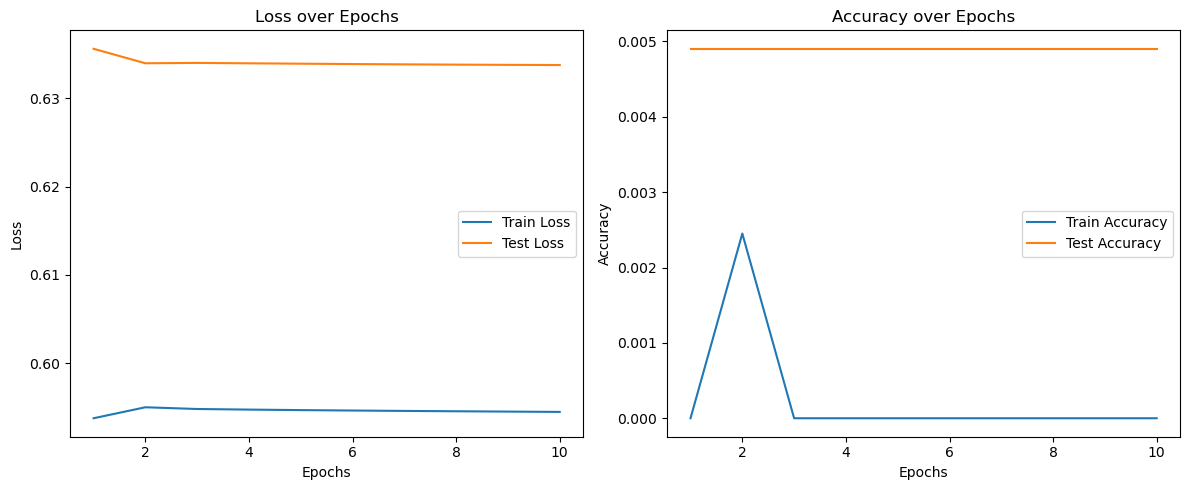

In [2]:
#1. 
# 입력 : 32,32
# 신경망 순서 : Convolution (W1) -> ReLU -> Pooling -> Convolution (W2) -> ReLU -> Pooling -> Affine (W3) -> ReLU -> Affine (W4) -> SigmoidWithLoss
# epochs = 10

import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from layers import Convolution, Relu, Pooling, Affine, SigmoidWithLoss, Dropout
from optimizer import Adam

# CNN 모델 정의
class DeepConvNet:
    def __init__(self, input_dim=(1, 32, 32),
                 conv_param_1={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_2={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 hidden_size=256, output_size=1):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size']) * 0.01
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size']) * 0.01
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])

        conv1_output_height = (input_dim[1] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        conv1_output_width = (input_dim[2] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        pool1_output_height, pool1_output_width = conv1_output_height // 2, conv1_output_width // 2

        conv2_output_height = (pool1_output_height + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        conv2_output_width = (pool1_output_width + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        pool2_output_height, pool2_output_width = conv2_output_height // 2, conv2_output_width // 2

        affine_input_size = conv_param_2['filter_num'] * pool2_output_height * pool2_output_width
        self.params['W3'] = np.random.randn(affine_input_size, hidden_size) * 0.01
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = np.random.randn(hidden_size, output_size) * 0.01
        self.params['b4'] = np.zeros(output_size)

        self.layers = [
            Convolution(self.params['W1'], self.params['b1'], stride=conv_param_1['stride'], pad=conv_param_1['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Convolution(self.params['W2'], self.params['b2'], stride=conv_param_2['stride'], pad=conv_param_2['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Affine(self.params['W3'], self.params['b3']),
            Relu(),
            #Dropout(0.5),
            Affine(self.params['W4'], self.params['b4'])
        ]
        self.last_layer = SigmoidWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = self.last_layer.backward(1)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        grads = {
            'W1': self.layers[0].dW, 'b1': self.layers[0].db,
            'W2': self.layers[3].dW, 'b2': self.layers[3].db,
            'W3': self.layers[6].dW, 'b3': self.layers[6].db,
            'W4': self.layers[8].dW, 'b4': self.layers[8].db
        }
        return grads

# 데이터 로딩 및 전처리 함수
def load_data(csv_file, img_folder, img_shape=(32, 32)):
    data = pd.read_csv(csv_file)
    images, labels = [], []

    for _, row in data.iterrows():
        img_path = os.path.join(img_folder, row['imageID'])
        img = Image.open(img_path).convert('L').resize(img_shape)
        images.append(np.asarray(img, dtype=np.float32) / 255.0)
        labels.append(row['binaryLabels'])

    images = np.array(images).reshape(-1, 1, *img_shape)
    labels = np.array(labels)

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    return images, labels

# 정확도 계산 함수
def accuracy(network, x_data, y_data):
    y_pred = network.predict(x_data)
    y_pred = np.round(y_pred)
    return accuracy_score(y_data, y_pred)

# 데이터 로드 및 분할
images, labels = load_data('./G1020.csv', './image_folder/jpg')
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 네트워크 및 옵티마이저 초기화
network = DeepConvNet()
optimizer = Adam()

# 학습 파라미터 설정
epochs = 10
batch_size = 16

# 손실과 정확도 기록을 위한 리스트 초기화
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# 학습 루프
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 미니배치 학습
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

    # 에포크별 손실 및 정확도 평가
    train_loss = network.loss(x_train, y_train)
    test_loss = network.loss(x_test, y_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracy = accuracy(network, x_train, y_train)
    test_accuracy = accuracy(network, x_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # 손실 및 정확도 출력
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/20
Train Loss: 0.5925, Test Loss: 0.6438
Train Accuracy: 0.0061, Test Accuracy: 0.0098
Epoch 2/20
Train Loss: 0.5927, Test Loss: 0.6372
Train Accuracy: 0.0159, Test Accuracy: 0.0147
Epoch 3/20
Train Loss: 0.5912, Test Loss: 0.6381
Train Accuracy: 0.0147, Test Accuracy: 0.0147
Epoch 4/20
Train Loss: 0.5901, Test Loss: 0.6388
Train Accuracy: 0.0196, Test Accuracy: 0.0196
Epoch 5/20
Train Loss: 0.5891, Test Loss: 0.6395
Train Accuracy: 0.0233, Test Accuracy: 0.0196
Epoch 6/20
Train Loss: 0.5880, Test Loss: 0.6403
Train Accuracy: 0.0319, Test Accuracy: 0.0196
Epoch 7/20
Train Loss: 0.5944, Test Loss: 0.6394
Train Accuracy: 0.0882, Test Accuracy: 0.0882
Epoch 8/20
Train Loss: 0.5857, Test Loss: 0.6422
Train Accuracy: 0.0392, Test Accuracy: 0.0294
Epoch 9/20
Train Loss: 0.5840, Test Loss: 0.6436
Train Accuracy: 0.0368, Test Accuracy: 0.0294
Epoch 10/20
Train Loss: 0.5829, Test Loss: 0.6443
Train Accuracy: 0.0368, Test Accuracy: 0.0392
Epoch 11/20
Train Loss: 0.5815, Test Loss: 0.6456

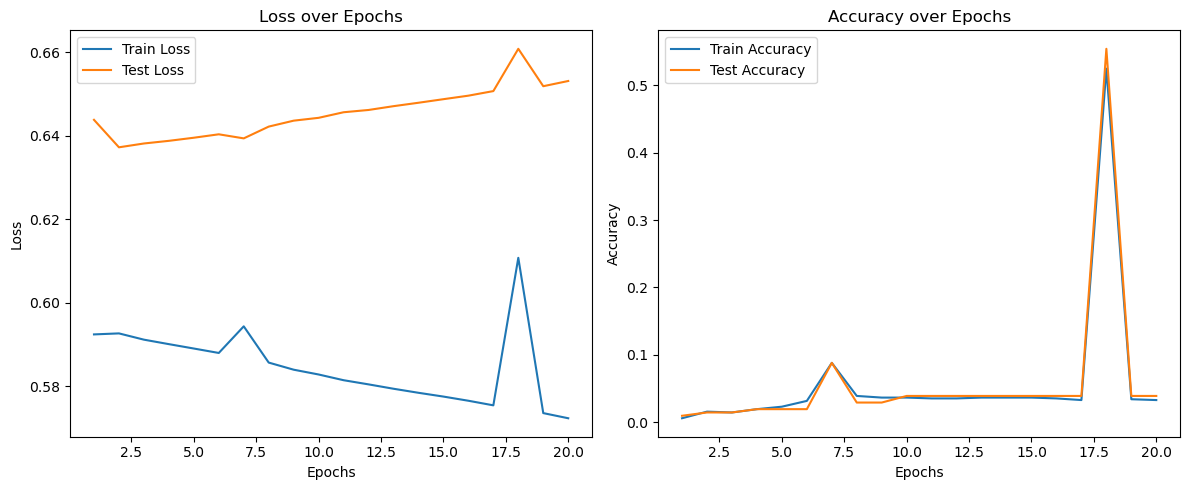

In [8]:
#2. 
# 입력 : 64,64
# 신경망 순서 : Convolution (W1) -> ReLU -> Pooling -> Convolution (W2) -> ReLU -> Pooling -> Affine (W3) -> ReLU -> Affine (W4) -> SigmoidWithLoss
# epochs = 20



import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from layers import Convolution, Relu, Pooling, Affine, SigmoidWithLoss, Dropout
from optimizer import Adam

# CNN 모델 정의
class DeepConvNet:
    def __init__(self, input_dim=(1, 64,64),
                 conv_param_1={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_2={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 hidden_size=256, output_size=1):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size']) * 0.01
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size']) * 0.01
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])

        conv1_output_height = (input_dim[1] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        conv1_output_width = (input_dim[2] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        pool1_output_height, pool1_output_width = conv1_output_height // 2, conv1_output_width // 2

        conv2_output_height = (pool1_output_height + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        conv2_output_width = (pool1_output_width + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        pool2_output_height, pool2_output_width = conv2_output_height // 2, conv2_output_width // 2

        affine_input_size = conv_param_2['filter_num'] * pool2_output_height * pool2_output_width
        self.params['W3'] = np.random.randn(affine_input_size, hidden_size) * 0.01
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = np.random.randn(hidden_size, output_size) * 0.01
        self.params['b4'] = np.zeros(output_size)

        self.layers = [
            Convolution(self.params['W1'], self.params['b1'], stride=conv_param_1['stride'], pad=conv_param_1['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Convolution(self.params['W2'], self.params['b2'], stride=conv_param_2['stride'], pad=conv_param_2['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Affine(self.params['W3'], self.params['b3']),
            Relu(),
            #Dropout(0.5),
            Affine(self.params['W4'], self.params['b4'])
        ]
        self.last_layer = SigmoidWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = self.last_layer.backward(1)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        grads = {
            'W1': self.layers[0].dW, 'b1': self.layers[0].db,
            'W2': self.layers[3].dW, 'b2': self.layers[3].db,
            'W3': self.layers[6].dW, 'b3': self.layers[6].db,
            'W4': self.layers[8].dW, 'b4': self.layers[8].db
        }
        return grads

# 데이터 로딩 및 전처리 함수
def load_data(csv_file, img_folder, img_shape=(64,64)):
    data = pd.read_csv(csv_file)
    images, labels = [], []

    for _, row in data.iterrows():
        img_path = os.path.join(img_folder, row['imageID'])
        img = Image.open(img_path).convert('L').resize(img_shape)
        images.append(np.asarray(img, dtype=np.float32) / 255.0)
        labels.append(row['binaryLabels'])

    images = np.array(images).reshape(-1, 1, *img_shape)
    labels = np.array(labels)

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    return images, labels

# 정확도 계산 함수
def accuracy(network, x_data, y_data):
    y_pred = network.predict(x_data)
    y_pred = np.round(y_pred)
    return accuracy_score(y_data, y_pred)

# 데이터 로드 및 분할
images, labels = load_data('./G1020.csv', './image_folder/jpg')
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 네트워크 및 옵티마이저 초기화
network = DeepConvNet()
optimizer = Adam()

# 학습 파라미터 설정
epochs = 20
batch_size = 16

# 손실과 정확도 기록을 위한 리스트 초기화
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# 학습 루프
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 미니배치 학습
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

    # 에포크별 손실 및 정확도 평가
    train_loss = network.loss(x_train, y_train)
    test_loss = network.loss(x_test, y_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracy = accuracy(network, x_train, y_train)
    test_accuracy = accuracy(network, x_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # 손실 및 정확도 출력
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/10
Train Loss: 0.8450, Test Loss: 0.8235
Train Accuracy: 0.4093, Test Accuracy: 0.4412
Epoch 2/10
Train Loss: 0.5991, Test Loss: 0.6357
Train Accuracy: 0.0686, Test Accuracy: 0.0735
Epoch 3/10
Train Loss: 0.5913, Test Loss: 0.6418
Train Accuracy: 0.0135, Test Accuracy: 0.0049
Epoch 4/10
Train Loss: 0.5913, Test Loss: 0.6404
Train Accuracy: 0.0172, Test Accuracy: 0.0049
Epoch 5/10
Train Loss: 0.5912, Test Loss: 0.6404
Train Accuracy: 0.0184, Test Accuracy: 0.0049
Epoch 6/10
Train Loss: 0.5911, Test Loss: 0.6417
Train Accuracy: 0.0208, Test Accuracy: 0.0049
Epoch 7/10
Train Loss: 0.5912, Test Loss: 0.6395
Train Accuracy: 0.0208, Test Accuracy: 0.0049
Epoch 8/10
Train Loss: 0.5909, Test Loss: 0.6417
Train Accuracy: 0.0233, Test Accuracy: 0.0049
Epoch 9/10
Train Loss: 0.5907, Test Loss: 0.6437
Train Accuracy: 0.0245, Test Accuracy: 0.0098
Epoch 10/10
Train Loss: 0.5904, Test Loss: 0.6445
Train Accuracy: 0.0245, Test Accuracy: 0.0098


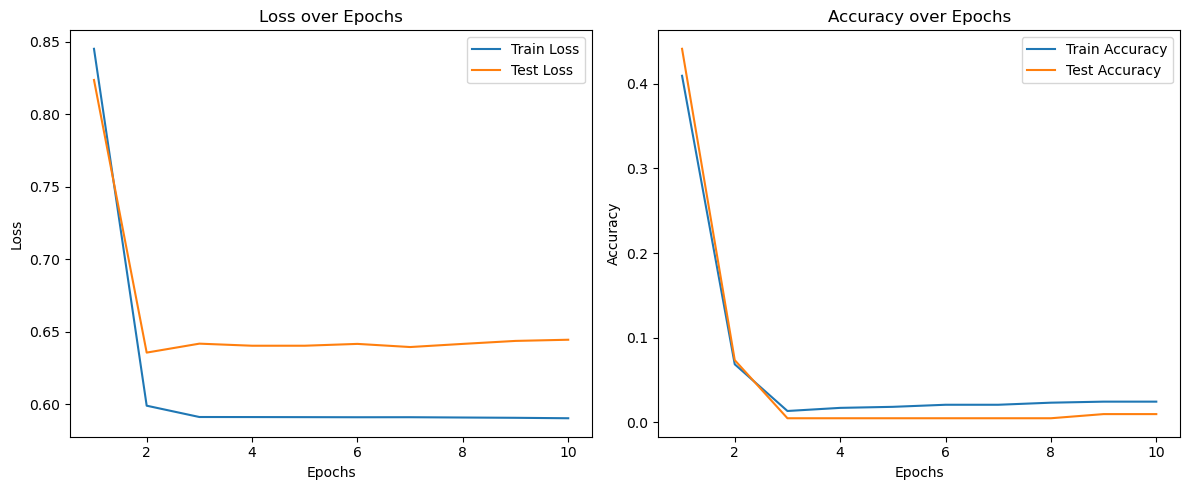

In [1]:
#3. 
# 입력 : 32,32
# 신경망 : 신경망 순서 : Convolution (W1) -> ReLU -> Pooling -> Convolution (W2) -> ReLU -> Pooling -> Affine (W3) -> ReLU -> Affine (W4) -> SigmoidWithLoss
# epochs = 10
# Adoam 학습률 : 0.001 -> 0.01

import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from layers import Convolution, Relu, Pooling, Affine, SigmoidWithLoss, Dropout
from optimizer import Adam

# CNN 모델 정의
class DeepConvNet:
    def __init__(self, input_dim=(1, 32, 32),
                 conv_param_1={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_2={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 hidden_size=256, output_size=1):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size']) * 0.01
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size']) * 0.01
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])

        conv1_output_height = (input_dim[1] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        conv1_output_width = (input_dim[2] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        pool1_output_height, pool1_output_width = conv1_output_height // 2, conv1_output_width // 2

        conv2_output_height = (pool1_output_height + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        conv2_output_width = (pool1_output_width + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        pool2_output_height, pool2_output_width = conv2_output_height // 2, conv2_output_width // 2

        affine_input_size = conv_param_2['filter_num'] * pool2_output_height * pool2_output_width
        self.params['W3'] = np.random.randn(affine_input_size, hidden_size) * 0.01
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = np.random.randn(hidden_size, output_size) * 0.01
        self.params['b4'] = np.zeros(output_size)

        self.layers = [
            Convolution(self.params['W1'], self.params['b1'], stride=conv_param_1['stride'], pad=conv_param_1['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Convolution(self.params['W2'], self.params['b2'], stride=conv_param_2['stride'], pad=conv_param_2['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Affine(self.params['W3'], self.params['b3']),
            Relu(),
            #Dropout(0.5),
            Affine(self.params['W4'], self.params['b4'])
        ]
        self.last_layer = SigmoidWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = self.last_layer.backward(1)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        grads = {
            'W1': self.layers[0].dW, 'b1': self.layers[0].db,
            'W2': self.layers[3].dW, 'b2': self.layers[3].db,
            'W3': self.layers[6].dW, 'b3': self.layers[6].db,
            'W4': self.layers[8].dW, 'b4': self.layers[8].db
        }
        return grads

# 데이터 로딩 및 전처리 함수
def load_data(csv_file, img_folder, img_shape=(32, 32)):
    data = pd.read_csv(csv_file)
    images, labels = [], []

    for _, row in data.iterrows():
        img_path = os.path.join(img_folder, row['imageID'])
        img = Image.open(img_path).convert('L').resize(img_shape)
        images.append(np.asarray(img, dtype=np.float32) / 255.0)
        labels.append(row['binaryLabels'])

    images = np.array(images).reshape(-1, 1, *img_shape)
    labels = np.array(labels)

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    return images, labels

# 정확도 계산 함수
def accuracy(network, x_data, y_data):
    y_pred = network.predict(x_data)
    y_pred = np.round(y_pred)
    return accuracy_score(y_data, y_pred)

# 데이터 로드 및 분할
images, labels = load_data('./G1020.csv', './image_folder/jpg')
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 네트워크 및 옵티마이저 초기화
network = DeepConvNet()
optimizer = Adam()

# 학습 파라미터 설정
epochs = 10
batch_size = 16

# 손실과 정확도 기록을 위한 리스트 초기화
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# 학습 루프
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 미니배치 학습
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

    # 에포크별 손실 및 정확도 평가
    train_loss = network.loss(x_train, y_train)
    test_loss = network.loss(x_test, y_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracy = accuracy(network, x_train, y_train)
    test_accuracy = accuracy(network, x_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # 손실 및 정확도 출력
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()



Epoch 1/20
Train Loss: 9.6082, Test Loss: 11.1743
Train Accuracy: 0.0012, Test Accuracy: 0.0000
Epoch 2/20
Train Loss: 9.5659, Test Loss: 11.3458
Train Accuracy: 0.0012, Test Accuracy: 0.0049
Epoch 3/20
Train Loss: 9.6929, Test Loss: 11.1743
Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch 4/20
Train Loss: 9.6929, Test Loss: 11.1743
Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch 5/20
Train Loss: 9.5236, Test Loss: 11.1743
Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch 6/20
Train Loss: 23.8729, Test Loss: 22.5184
Train Accuracy: 0.0025, Test Accuracy: 0.0000
Epoch 7/20
Train Loss: 9.3543, Test Loss: 11.0050
Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch 8/20
Train Loss: 9.1439, Test Loss: 11.0050
Train Accuracy: 0.0000, Test Accuracy: 0.0000
Epoch 9/20
Train Loss: 8.8545, Test Loss: 13.3950
Train Accuracy: 0.0208, Test Accuracy: 0.0245
Epoch 10/20
Train Loss: 8.3006, Test Loss: 11.1767
Train Accuracy: 0.0037, Test Accuracy: 0.0049
Epoch 11/20
Train Loss: 8.5924, Test L

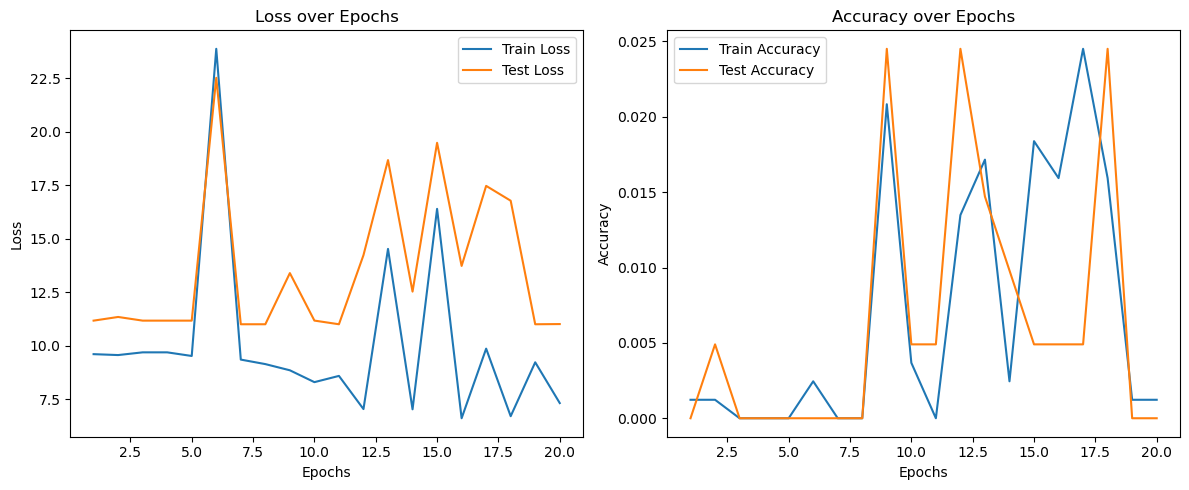

In [1]:
#4.
# 입력 : 128,128
# 신경망 : 신경망 순서 : Convolution (W1) -> ReLU -> Pooling -> Convolution (W2) -> ReLU -> Pooling -> Affine (W3) -> ReLU -> Affine (W4) -> SigmoidWithLoss
# epochs = 20
# Adoam 학습률 :  0.01


import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from layers import Convolution, Relu, Pooling, Affine, SigmoidWithLoss, Dropout
from optimizer import Adam


# He 초기화 함수
def he_init(shape):
    return np.random.randn(*shape) * np.sqrt(2.0 / shape[1])

# CNN 모델 정의
class DeepConvNet:
    def __init__(self, input_dim=(3, 128, 128),  # 입력 크기를 128x128로 변경
                 conv_param_1={'filter_num': 16, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param_2={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 hidden_size=256, output_size=1):

        # 가중치 초기화 (He 초기화 적용)
        self.params = {}
        self.params['W1'] = he_init((conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size']))
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = he_init((conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size']))
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])

        conv1_output_height = (input_dim[1] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        conv1_output_width = (input_dim[2] + 2 * conv_param_1['pad'] - conv_param_1['filter_size']) // conv_param_1['stride'] + 1
        pool1_output_height, pool1_output_width = conv1_output_height // 2, conv1_output_width // 2

        conv2_output_height = (pool1_output_height + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        conv2_output_width = (pool1_output_width + 2 * conv_param_2['pad'] - conv_param_2['filter_size']) // conv_param_2['stride'] + 1
        pool2_output_height, pool2_output_width = conv2_output_height // 2, conv2_output_width // 2

        affine_input_size = conv_param_2['filter_num'] * pool2_output_height * pool2_output_width
        self.params['W3'] = he_init((affine_input_size, hidden_size))
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = he_init((hidden_size, output_size))
        self.params['b4'] = np.zeros(output_size)

        self.layers = [
            Convolution(self.params['W1'], self.params['b1'], stride=conv_param_1['stride'], pad=conv_param_1['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Convolution(self.params['W2'], self.params['b2'], stride=conv_param_2['stride'], pad=conv_param_2['pad']),
            Relu(),
            Pooling(pool_h=2, pool_w=2, stride=2),
            Affine(self.params['W3'], self.params['b3']),
            Relu(),
            Affine(self.params['W4'], self.params['b4'])
        ]
        self.last_layer = SigmoidWithLoss()
        
    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        self.loss(x, t)
        dout = self.last_layer.backward(1)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        grads = {
            'W1': self.layers[0].dW, 'b1': self.layers[0].db,
            'W2': self.layers[3].dW, 'b2': self.layers[3].db,
            'W3': self.layers[6].dW, 'b3': self.layers[6].db,
            'W4': self.layers[8].dW, 'b4': self.layers[8].db
        }
        return grads


# 데이터 로딩 및 전처리 함수
def load_data(csv_file, img_folder, img_shape=(128, 128)):  # 이미지 크기를 128x128로 변경
    data = pd.read_csv(csv_file)
    images, labels = [], []

    for _, row in data.iterrows():
        img_path = os.path.join(img_folder, row['imageID'])
        img = Image.open(img_path).convert('RGB').resize(img_shape)  # RGB로 변환
        images.append(np.asarray(img, dtype=np.float32) / 255.0)
        labels.append(row['binaryLabels'])

    images = np.array(images).reshape(-1, 3, *img_shape)  # 채널 수를 3으로 변경
    labels = np.array(labels)

    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    return images, labels

# 정확도 계산 함수
def accuracy(network, x_data, y_data):
    y_pred = network.predict(x_data)
    y_pred = np.round(y_pred)
    return accuracy_score(y_data, y_pred)

# 데이터 로드 및 분할
images, labels = load_data('./G1020.csv', './image_folder/jpg')
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 네트워크 및 옵티마이저 초기화
network = DeepConvNet()
optimizer = Adam()  

# 학습 파라미터 설정
epochs = 20
batch_size = 16

# 손실과 정확도 기록을 위한 리스트 초기화
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# 학습 루프
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # 미니배치 학습
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        grads = network.gradient(x_batch, y_batch)
        optimizer.update(network.params, grads)

    # 에포크별 손실 및 정확도 평가
    train_loss = network.loss(x_train, y_train)
    test_loss = network.loss(x_test, y_test)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    train_accuracy = accuracy(network, x_train, y_train)
    test_accuracy = accuracy(network, x_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # 손실 및 정확도 출력
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# 손실 및 정확도 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
